In [2]:
import seaborn
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [3]:
# Load the data
transactions = pd.read_csv('transactions.csv')

In [4]:
# Summary statistics on amount column
print(transactions['amount'].describe())
print(transactions.head())
print(transactions.info())

count    1.999990e+05
mean     1.802425e+05
std      6.255482e+05
min      0.000000e+00
25%      1.338746e+04
50%      7.426695e+04
75%      2.086376e+05
max      5.204280e+07
Name: amount, dtype: float64
   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     8  CASH_OUT  158007.12   C424875646           0.00            0.00   
1   236  CASH_OUT  457948.30  C1342616552           0.00            0.00   
2    37   CASH_IN  153602.99   C900876541    11160428.67     11314031.67   
3   331  CASH_OUT   49555.14   C177696810       10865.00            0.00   
4   250  CASH_OUT   29648.02   C788941490           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C1298177219       474016.32      1618631.97        0  
1  C1323169990      2720411.37      3178359.67        0  
2   C608741097      3274930.56      3121327.56        0  
3   C462716348            0.00        49555.14        0  
4  C1971700992        56933.09        86581.10  

In [5]:
# Create isPayment field
transactions['isPayment'] = 0
transactions['isPayment'][transactions['type'].isin(['PAYMENT','DEBIT'])] = 1

# Create isMovement field
transactions['isMovement'] = 0
transactions['isMovement'][transactions['type'].isin(['CASH_OUT', 'TRANSFER'])] = 1

# Create accountDiff field
transactions['accountDiff'] = abs(transactions['oldbalanceOrg'] - transactions['oldbalanceDest'])

# Create features and label variables
features = transactions[['amount', 'isPayment', 'isMovement', 'accountDiff']]
labels = transactions[['isFraud']]

/var/folders/rq/t1zwhw110z107g7z9_lt036m0000gn/T/ipykernel_26646/2682292587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['isPayment'][transactions['type'].isin(['PAYMENT','DEBIT'])] = 1
/var/folders/rq/t1zwhw110z107g7z9_lt036m0000gn/T/ipykernel_26646/2682292587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['isMovement'][transactions['type'].isin(['CASH_OUT', 'TRANSFER'])] = 1


In [6]:
# Warning above is no problem (for now...)
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels,  test_size=0.2, random_state = 100)

In [7]:
# Normalize the features variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Normalize the features variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
print(X_train.shape)
print(y_train.shape)

(159999, 4)
(159999, 1)


In [10]:
# Fit the model to the training data
lrm = LogisticRegression()
lrm.fit(X_train, y_train)

/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [11]:
# Score the model on the training data
print("Training score:")
print(lrm.score(X_train, y_train))

# Score the model on the test data
print("Test score:")
print(lrm.score(X_test, y_test))

# Score the model's predictions
y_pred = lrm.predict(X_test)
print("Acc score: ")
print(accuracy_score(y_test, y_pred))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred))

Training score:
0.9985937412108825
Test score:
0.99845
Acc score: 
0.99845
Confusion matrix
[[39938     2]
 [   60     0]]


In [12]:
# Print the model coefficients
print("\nFeature coefficients")
for i in range(len(lrm.coef_[0])):
  print("  ", features.columns[i], ": ", lrm.coef_[0][i])

abs_coefs = [abs(ele) for ele in lrm.coef_[0]]
most = max(abs_coefs)
least = min(abs_coefs)
print("Most important:  ", features.columns[abs_coefs.index(most)])
print("Least important: ", features.columns[abs_coefs.index(least)])


Feature coefficients
   amount :  0.25172153785911777
   isPayment :  -0.7489984538367008
   isMovement :  2.301134175106104
   accountDiff :  -0.7391858599809403
Most important:   isMovement
Least important:  amount


### Now trying KNN to classify fraudulent transactions

First train a series of KNN clasifiers for a range of values of K between, measuring precision and accuracy.

In [13]:
k_vals = {}
for k in range(1, 21):
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(X_train, y_train)
    knn_preds = knn_clf.predict(X_test)
    acc_score = knn_clf.score(X_test, y_test)
    precision = precision_score(y_test, knn_preds, zero_division=1)
    recall = recall_score(y_test, knn_preds, zero_division=1)
    print("K = ", k, "  Accuracy : ", round(acc_score,3), "  Precision: ", round(precision,3), "  Recall: ", round(recall,3))
    print(confusion_matrix(y_test, knn_preds))
    k_vals[k] = [precision, recall]

/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  1   Accuracy :  0.998   Precision:  0.208   Recall:  0.183
[[39898    42]
 [   49    11]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  2   Accuracy :  0.998   Precision:  0.429   Recall:  0.05
[[39936     4]
 [   57     3]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  3   Accuracy :  0.998   Precision:  0.455   Recall:  0.083
[[39934     6]
 [   55     5]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  4   Accuracy :  0.998   Precision:  0.5   Recall:  0.017
[[39939     1]
 [   59     1]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  5   Accuracy :  0.999   Precision:  0.667   Recall:  0.033
[[39939     1]
 [   58     2]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  6   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  7   Accuracy :  0.999   Precision:  0.667   Recall:  0.033
[[39939     1]
 [   58     2]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  8   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  9   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  10   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  11   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  12   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  13   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  14   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  15   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  16   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  17   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  18   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  19   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K =  20   Accuracy :  0.998   Precision:  1.0   Recall:  0.0
[[39940     0]
 [   60     0]]


In [15]:
max_prec = max(k_vals.items(), key=operator.itemgetter(1))[1]
best_k = max(k_vals.items(), key=operator.itemgetter(1))[0]
print("Best K =", best_k, "  Best precision:", max_prec)

Best K = 6   Best precision: [1.0, 0.0]


In [16]:
# Train a new KNN classifier with best performing K val
knn_clf_best = KNeighborsClassifier(n_neighbors = best_k)
knn_clf_best.fit(X_train, y_train)
predictions = knn_clf.predict(X_test)

/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [17]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[39940     0]
 [   60     0]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

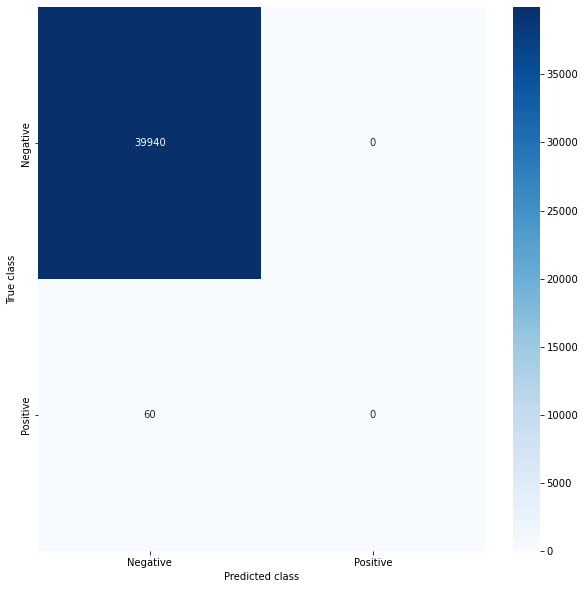

In [20]:
class_names = ['Negative', 'Positive']
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = seaborn.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39940
           1       0.00      0.00      0.00        60

    accuracy                           1.00     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       1.00      1.00      1.00     40000



/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=100)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [23]:
# Train a new KNN classifier with best performing K val with oversampled data
knn_clf_best = KNeighborsClassifier(n_neighbors = best_k)
knn_clf_best.fit(X_train_over, y_train_over)
predictions = knn_clf.predict(X_test)

/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39940
           1       0.00      0.00      0.00        60

    accuracy                           1.00     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       1.00      1.00      1.00     40000



/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielhardej/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

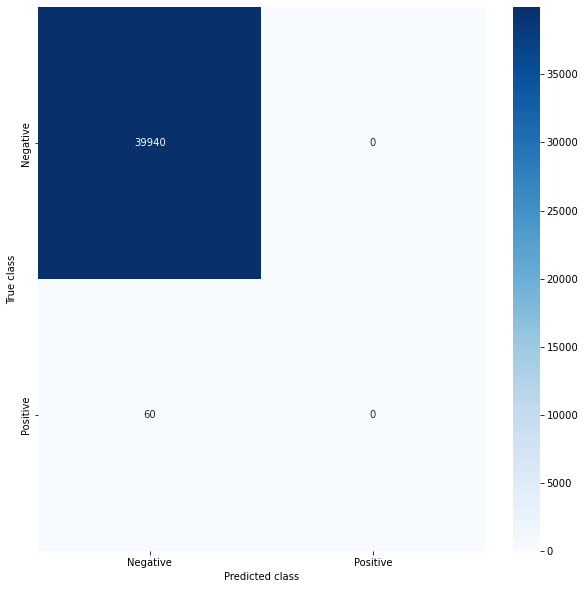

In [25]:
cm = confusion_matrix(y_test, predictions)
class_names = ['Negative', 'Positive']
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = seaborn.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)